# Data Exploration and Preprocessing
TCGA Reannotated Ovarian Cancer Clinical Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from scipy import stats
from openpyxl import load_workbook
import sidetable
from functools import reduce
import itertools
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import time
import statsmodels.api as sm
from scipy import stats
from lifelines import CoxPHFitter

device = torch.device('cpu')

Import Data

In [2]:
# Villalobos 2018 reannotated TCGA data (https://ascopubs.org/doi/suppl/10.1200/CCI.17.00096)
tcga_ov_1 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-1.xlsx',
                          sheet_name='Master clinical dataset'
                          )

tcga_ov_2 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-2.xlsx',
                          sheet_name='Months'
                          )

tcga_ov_3 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-3.xlsx',
                          sheet_name='clinical_drug_all_OV.txt'
                          )

# TCGA Drug standardization (https://gdisc.bme.gatech.edu/cgi-bin/gdisc/tap5.cgi#)
drugs = pd.read_csv('./Data/DrugCorrection1.csv')
drugs['Correction'] = drugs['Correction'].str.strip()

## Clean and Reorganize

TCGA 3: Clean

In [3]:
# Drop columns with all missing values
print(tcga_ov_3.shape)
print(tcga_ov_3.isnull().sum(), '\n')
tcga_ov_3_drop = tcga_ov_3.dropna(axis=1, how='all')
# Drop rows where drug is missing
tcga_ov_3_drop = tcga_ov_3_drop[tcga_ov_3_drop['drug_name'].notna()]
# Drop rows where start AND end are missing (right now it's actually OR, see below)
tcga_ov_3_drop = tcga_ov_3_drop.dropna(how='any', subset=['days_to_drug_therapy_end', 'days_to_drug_therapy_start']) #change to how='all' when figure out what to do with start OR end missing

# Standardize drug names
    # Merge using values from TCGA drug standardization (https://gdisc.bme.gatech.edu/cgi-bin/gdisc/tap5.cgi)
tcga_ov_3_clean = tcga_ov_3_drop.merge(drugs, how='left', left_on='drug_name', right_on='OldName').drop(['OldName'], axis=1)
    # Additional replacement rules
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Doxoribicin', 'Correction'] = 'Doxorubicin'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'gemcitabin', 'Correction'] = 'Gemcitabine'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Hexlalen', 'Correction'] = 'Altretamine'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Cisplatin/Gemzar', 'Correction'] = 'Cisplatin' # This applies to only one line, which has another sample just for Gemzar (Gemcitabine)
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Ilex', 'Correction'] = 'Ilex'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'ILIZ', 'Correction'] = 'ILIZ'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Lily', 'Correction'] = 'Lily'

    # Print replacement rules and replace 'drug_name'
drug_name_old = tcga_ov_3_clean['drug_name']
drug_name_new = tcga_ov_3_clean['Correction']
rules = pd.DataFrame({'drug_name_old': drug_name_old, 'drug_name_new': drug_name_new}).drop_duplicates().sort_values(by=['drug_name_old']).reset_index().drop('index', axis=1)

pd.set_option('display.max_rows', None)
print('Replacement Rules:\n', rules.head(), '\n')
pd.reset_option('max_rows')

tcga_ov_3_clean['drug_name'] = tcga_ov_3_clean['Correction']
tcga_ov_3_clean = tcga_ov_3_clean.drop('Correction', axis=1)

    # List of drugs in dataset
drug_list = [x for x in list(tcga_ov_3_clean['drug_name'].drop_duplicates()) if str(x) != 'nan']
drug_list.sort()
print('Unique Drugs:', len(drug_list), '\n', drug_list, '\n')

# Drop where therapy start = therapy end
tcga_ov_3_clean = tcga_ov_3_clean[tcga_ov_3_clean['days_to_drug_therapy_end'] != tcga_ov_3_clean['days_to_drug_therapy_start']] 

(2463, 19)
bcr_patient_barcode                 0
bcr_drug_barcode                    0
days_to_drug_therapy_end          339
days_to_drug_therapy_start        145
days_to_drug_treatment_end       2463
days_to_drug_treatment_start     2463
dosage_units                     2463
drug_category                       0
drug_dosage                      2463
drug_name                          11
initial_course                   2463
number_cycles                     391
regimen_indication                  2
regimen_indication_notes         2328
route_of_administration           243
route_of_administration_notes    2126
therapy_ongoing                   167
total_dose                        746
total_dose_units                  715
dtype: int64 

Replacement Rules:
            drug_name_old            drug_name_new
0         5F4 Leucovorin  Fluorouracil+Leucovorin
1            90Y-HU3S193                  Hu3S193
2                AMG 706                Motesanib
3  Abagovomab or Placebo        

TCGA 3: Fix/standardize time variables and fix order of therapy lines

In [4]:
# Fix values where start and end are switched
tcga_ov_3_clean.loc[tcga_ov_3_clean['days_to_drug_therapy_start'] > tcga_ov_3_clean['days_to_drug_therapy_end'], ['days_to_drug_therapy_start', 'days_to_drug_therapy_end']] = tcga_ov_3_clean.loc[tcga_ov_3_clean['days_to_drug_therapy_start'] > tcga_ov_3_clean['days_to_drug_therapy_end'], ['days_to_drug_therapy_end', 'days_to_drug_therapy_start']].values

# Set earliest drug therapy start to zero and subtract everything else by min days
ther_start = tcga_ov_3_clean.groupby('bcr_patient_barcode')['days_to_drug_therapy_start']
tcga_timefix = tcga_ov_3_clean.assign(start_day=ther_start.transform(min))
      # keep start days for later use with tcga_ov_1
tcga_start_days = tcga_timefix[['bcr_patient_barcode', 'start_day']].drop_duplicates()

tcga_timefix['therapy_start'] = tcga_timefix['days_to_drug_therapy_start'] - tcga_timefix['start_day']
tcga_timefix['therapy_end'] = tcga_timefix['days_to_drug_therapy_end'] - tcga_timefix['start_day']
tcga_timefix = tcga_timefix.drop(['days_to_drug_therapy_end', 'days_to_drug_therapy_start', 'start_day'], axis=1)
tcga_timefix = tcga_timefix.sort_values(by=['bcr_patient_barcode', 'therapy_start', 'therapy_end'])

# Set up state list for each patient: barcode, timing, drug combo
tcga_drug_lines = []
for barcode in tcga_timefix['bcr_patient_barcode'].unique():
    tcga_time = tcga_timefix[tcga_timefix['bcr_patient_barcode'] == barcode]
    tcga_time = tcga_time[['therapy_start', 'therapy_end', 'drug_name']].drop_duplicates(keep='first').values.tolist() # Drop duplicate drugs that have different dosages or administration but same timing

    points = [] # list of (offset, plus/minus, drug) tuples
    for start,stop,drug in tcga_time:
        points.append((start,'+',drug))
        points.append((stop,'-',drug))
    points.sort()

    ranges = [] # output list of (start, stop, drug_set) tuples
    current_set = []
    last_start = None
    for offset,pm,drug in points:
        if pm == '+':
            if last_start is not None:
                ranges.append([last_start,offset,list(set(current_set.copy()))])
            current_set.append(drug)
            last_start = offset
        elif pm == '-':
            ranges.append([last_start,offset,list(set(current_set.copy()))])
            current_set.remove(drug)
            last_start = offset

    # Finish off
    if last_start is not None:
        ranges.append([last_start,offset,list(set(current_set.copy()))])

    # Remove the ranges where start = stop
    range_drug = []
    for i in range(len(ranges)):
        if ranges[i][0] != ranges[i][1]: # add condition:  <& (ranges[i][2] != [])> to drop no-drug periods
            range_drug.append(ranges[i])

    # Sort drugs in each drug combo
    for i in range(len(range_drug)):
        range_drug[i][2].sort()

    # Remove overlapping/back-to-back duplicate lines. Drop this section if decide to do something with dosages
    ranges_final = []
    for line in range(0, len(range_drug)-1):
        if (range_drug[line+1][2] == range_drug[line][2]) & (range_drug[line+1][0] <= range_drug[line][1]):
            range_drug[line][1] = range_drug[line+1][1]
            range_drug[line+1][0] = range_drug[line][0]
        if (range_drug[line][2] != range_drug[line+1][2]) | (range_drug[line][0] != range_drug[line+1][0]):
            ranges_final.append(range_drug[line])
    ranges_final.append(range_drug[len(range_drug)-1])

    # Add the number of previous lines of therapy
    for line in range(len(ranges_final)):
        if line == 0:
            ranges_final[line].append(0) 
        elif ranges_final[line-1][2] == []:
            ranges_final[line].append(ranges_final[line-1][3])
        else:
            ranges_final[line].append(ranges_final[line-1][3] + 1)
    
    # Add treat transition var
    for line in range(len(ranges_final)):
        try:
            if (ranges_final[line][2] != []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30))
            elif (ranges_final[line][2] != []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30) - 1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(0)
        except IndexError:
            ranges_final[line].append(0)
    
    # Add no treat transition var
    for line in range(len(ranges_final)):
        try:
            if (ranges_final[line][2] != []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(0)                
            elif (ranges_final[line][2] != []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30) - 1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30))
        except IndexError:
            ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30)-1)

    # Add patient barcodes
    for line in range(len(ranges_final)):
        ranges_final[line].insert(0, barcode)
    

    tcga_drug_lines.extend(ranges_final)

tcga_drug_lines[3] = ['TCGA-04-1332', 0.0, 151.0, ['Carboplatin', 'Paclitaxel', 'Topotecan'], 0, 5, 1] # Special case to fix. Make sure to check this if make changes above

# Back to df
lines_df = pd.DataFrame(tcga_drug_lines, columns=['bcr_patient_barcode', 'start', 'end', 'therapy', 'previous_lines', 'treat', 'no_treat'])

# List of patient barcodes
tcga_barcodes = list(lines_df['bcr_patient_barcode'].unique())

# Notes
    # One thing to be aware of is that this code drops all values where therapy start and therapy end are equal

TCGA 1: Clean

In [5]:
# Keep subset of variables 
print('NaNs: ', tcga_ov_1.isnull().sum())
tcga_ov_1_keep = tcga_ov_1[['bcr_patient_barcode',
                            'total_days_overall_survival',
                            'outcome_overall_survival_censoring',
                            # 'vital_status',
                            # 'days_to_tumor_progression',
                            # 'days_to_death',
                            # 'days_to_last_followup',
                            # 'days_to_tumor_recurrence',
                            # 'time_to_failure',  
                            # 'Cycles_of_adjuvant_therapy',
                            # 'Adjuvant_chemotherapy_dose_intensity',
                            'age_at_initial_pathologic_diagnosis',
                            # 'anatomic_organ_subdivision',
                            # 'days_to_birth',
                            # 'initial_pathologic_diagnosis_method',
                            # 'person_neoplasm_cancer_status',
                            # 'pretreatment_history',
                            # 'primary_therapy_outcome_success', # ask EKO about this
                            'race',
                            # 'residual_tumor',
                            # 'site_of_tumor_first_recurrence',
                            # 'tissue_source_site',
                            'tumor_grade',
                            # 'tumor_residual_disease',
                            'tumor_stage',
                            # 'tumor_tissue_site'
                            # 'year_of_initial_pathologic_diagnosis',
                            # 'Days off platinum prior to recurrence 1st line',
                            # 'Last day of platinum 1st line',
                            # 'Chemotherapy number of lines of therapy'
                            ]]

# Drop cases that don't have a survival metric
tcga_ov_1_keep = tcga_ov_1_keep.dropna(subset=['total_days_overall_survival'])
tcga_ov_1_keep.drop(tcga_ov_1_keep[tcga_ov_1_keep['total_days_overall_survival'] == 'cannot assess'].index, inplace=True)

# Only keep samples that are in the cleaned 'lines' data
tcga_ov_1_keep = tcga_ov_1_keep[tcga_ov_1_keep['bcr_patient_barcode'].isin(tcga_barcodes)].sort_values(by=['bcr_patient_barcode']).reset_index().drop('index', axis=1)

# Adjust final survival by start of therapy day
tcga_start_days = tcga_start_days[tcga_start_days['bcr_patient_barcode'].isin(tcga_barcodes)].sort_values(by=['bcr_patient_barcode']).reset_index().drop('index', axis=1)
tcga_ov_1_keep['total_days_overall_survival'] = tcga_ov_1_keep['total_days_overall_survival'] - tcga_start_days['start_day'] # this needs work, getting some negative values

# Fill blanks
tcga_ov_1_keep = tcga_ov_1_keep.replace(r'^\s*$', np.nan, regex=True)
tcga_ov_1_keep = tcga_ov_1_keep.replace(np.nan, 'NOT SPECIFIED', regex=True)

# Deceased only
tcga_ov_1_keep_d = tcga_ov_1_keep.loc[tcga_ov_1_keep['outcome_overall_survival_censoring'] == 1].reset_index(drop=True)

# Save CSVs
tcga_ov_1_keep.to_csv('tcga_ov_1_keep.csv', index=False)
tcga_ov_1_keep_d.to_csv('tcga_ov_1_keep_d.csv', index=False)

# Show data
tcga_ov_1_keep

NaNs:  bcr_patient_barcode                                 4
total_days_overall_survival                        28
outcome_overall_survival_censoring                 16
vital_status                                       34
days_to_tumor_progression                         570
                                                 ... 
5th_chemo_regimen_days_outcome                    524
6th_chemo_regimen_days_outcome                    552
Days off platinum prior to recurrence 1st line     99
Last day of platinum 1st line                     108
Chemotherapy number of lines of therapy            27
Length: 72, dtype: int64


,bcr_patient_barcode,total_days_overall_survival,outcome_overall_survival_censoring,age_at_initial_pathologic_diagnosis,race,tumor_grade,tumor_stage
0,TCGA-04-1331,1300.0,1,79.0,WHITE,G3,IIIC
1,TCGA-04-1332,1217.0,1,70.0,WHITE,G3,IIIC
2,TCGA-04-1336,1445.0,0,55.0,WHITE,G3,IIIB
3,TCGA-04-1338,1418.0,0,78.0,WHITE,G3,IIIC
4,TCGA-04-1342,531.0,1,80.0,WHITE,G2,IV
...,...,...,...,...,...,...,...
455,TCGA-61-2113,627.0,1,54.0,WHITE,G3,IIC
456,TCGA-61-2610,1550.0,1,61.0,WHITE,G3,IIIC
457,TCGA-61-2611,417.0,1,40.0,WHITE,G3,IIIC
458,TCGA-61-2612,173.0,1,63.0,WHITE,G3,IIIC


Data summary table(s)

In [6]:
############## Fix so that if a wb doesn't already exist it creates one

book = load_workbook('Table_1.xlsx')
book.template = False

writer = pd.ExcelWriter('Table_1.xlsx', engine='openpyxl')
writer.book = book

##################### All Patients
# Race
try:
    del book['race']
except:
    pass
tcga_ov_1_keep.stb.freq(['race']).to_excel(writer, sheet_name='race')

# Tumor grade
try:
    del book['tumor grade']
except:
    pass
tcga_ov_1_keep.stb.freq(['tumor_grade']).to_excel(writer, sheet_name='tumor grade')

# Tumor stage
try:
    del book['tumor stage']
except:
    pass
tcga_ov_1_keep.stb.freq(['tumor_stage']).to_excel(writer, sheet_name='tumor stage')

# Death
try:
    del book['death']
except:
    pass
tcga_ov_1_keep.stb.freq(['outcome_overall_survival_censoring']).to_excel(writer, sheet_name='death')
# Age
try:
    del book['age']
except:
    pass
pd.DataFrame(tcga_ov_1_keep['age_at_initial_pathologic_diagnosis'].describe()).to_excel(writer, sheet_name='age')

# Overall survival
try:
    del book['days survival']
except:
    pass
pd.DataFrame(tcga_ov_1_keep['total_days_overall_survival'].describe()).to_excel(writer, sheet_name='days survival')

##################### Deceased Patients
# Race
try:
    del book['race_d']
except:
    pass
tcga_ov_1_keep_d.stb.freq(['race']).to_excel(writer, sheet_name='race_d')

# Tumor grade
try:
    del book['tumor grade_d']
except:
    pass
tcga_ov_1_keep_d.stb.freq(['tumor_grade']).to_excel(writer, sheet_name='tumor grade_d')

# Tumor stage
try:
    del book['tumor stage_d']
except:
    pass
tcga_ov_1_keep_d.stb.freq(['tumor_stage']).to_excel(writer, sheet_name='tumor stage_d')

# Age
try:
    del book['age_d']
except:
    pass
pd.DataFrame(tcga_ov_1_keep_d['age_at_initial_pathologic_diagnosis'].describe()).to_excel(writer, sheet_name='age_d')

# Overall survival
try:
    del book['days survival_d']
except:
    pass
pd.DataFrame(tcga_ov_1_keep_d['total_days_overall_survival'].describe()).to_excel(writer, sheet_name='days survival_d')

writer.save()
writer.close()

Add death dummy to drug lines data

In [7]:
# Merge in final death event for each patient
lines_df_2 = lines_df.merge(tcga_ov_1_keep[['bcr_patient_barcode', 'outcome_overall_survival_censoring', 'race', 
                                            'age_at_initial_pathologic_diagnosis', 'tumor_stage', 'tumor_grade']],
                            on='bcr_patient_barcode').rename(columns={'bcr_patient_barcode': 'patient', 'outcome_overall_survival_censoring': 'death', 'age_at_initial_pathologic_diagnosis': 'age'})

# Only keep death event on last line
lines_df_2.loc[lines_df_2['patient'] == lines_df_2['patient'].shift(-1), 'death'] = 0

# Fix no treat on last line where death = 0
def fix_notreat(row):
    if (row['treat'] == 0) & (row['no_treat'] == 0) & (row['death'] == 0):
        return 1
    else:
        return row['no_treat']
lines_df_2['no_treat'] = lines_df_2.apply(lambda row: fix_notreat(row), axis=1)

# Total events
lines_df_2['total_ev'] = lines_df_2.apply(lambda row: max(1, row['treat'] + row['no_treat'] + row['death']), axis=1)

# Function to get indices of a therapy
def get_index_pos(my_list, val):
    return [i for i, x in enumerate(my_list) if x == val]

lines_df_2

,patient,start,end,therapy,previous_lines,treat,no_treat,death,race,age,tumor_stage,tumor_grade,total_ev
0,TCGA-04-1331,0.0,133.0,"[Carboplatin, Paclitaxel]",0,4,1,0,WHITE,79.0,IIIC,G3,5
1,TCGA-04-1331,133.0,445.0,[],1,1,10,0,WHITE,79.0,IIIC,G3,11
2,TCGA-04-1331,445.0,462.0,[Dortezomib],1,0,0,1,WHITE,79.0,IIIC,G3,1
3,TCGA-04-1332,0.0,151.0,"[Carboplatin, Paclitaxel, Topotecan]",0,5,1,0,WHITE,70.0,IIIC,G3,6
4,TCGA-04-1332,151.0,396.0,[],1,1,8,0,WHITE,70.0,IIIC,G3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,TCGA-61-2610,500.0,561.0,[],2,1,2,0,WHITE,61.0,IIIC,G3,3
1913,TCGA-61-2610,561.0,1101.0,[Doxorubicin],2,0,17,1,WHITE,61.0,IIIC,G3,18
1914,TCGA-61-2611,0.0,238.0,"[Carboplatin, Paclitaxel]",0,0,7,1,WHITE,40.0,IIIC,G3,8
1915,TCGA-61-2612,0.0,131.0,"[Carboplatin, Paclitaxel]",0,0,4,1,WHITE,63.0,IIIC,G3,5


In [8]:
# Create version of final dataset that only includes patients who died
d_pats = list(tcga_ov_1_keep['bcr_patient_barcode'].loc[tcga_ov_1_keep['outcome_overall_survival_censoring'] == 1])

lines_df_d = lines_df_2[lines_df_2['patient'].isin(d_pats)].reset_index().drop(['index'], axis=1)
lines_df_d

,patient,start,end,therapy,previous_lines,treat,no_treat,death,race,age,tumor_stage,tumor_grade,total_ev
0,TCGA-04-1331,0.0,133.0,"[Carboplatin, Paclitaxel]",0,4,1,0,WHITE,79.0,IIIC,G3,5
1,TCGA-04-1331,133.0,445.0,[],1,1,10,0,WHITE,79.0,IIIC,G3,11
2,TCGA-04-1331,445.0,462.0,[Dortezomib],1,0,0,1,WHITE,79.0,IIIC,G3,1
3,TCGA-04-1332,0.0,151.0,"[Carboplatin, Paclitaxel, Topotecan]",0,5,1,0,WHITE,70.0,IIIC,G3,6
4,TCGA-04-1332,151.0,396.0,[],1,1,8,0,WHITE,70.0,IIIC,G3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,TCGA-61-2610,500.0,561.0,[],2,1,2,0,WHITE,61.0,IIIC,G3,3
1260,TCGA-61-2610,561.0,1101.0,[Doxorubicin],2,0,17,1,WHITE,61.0,IIIC,G3,18
1261,TCGA-61-2611,0.0,238.0,"[Carboplatin, Paclitaxel]",0,0,7,1,WHITE,40.0,IIIC,G3,8
1262,TCGA-61-2612,0.0,131.0,"[Carboplatin, Paclitaxel]",0,0,4,1,WHITE,63.0,IIIC,G3,5


Create version of data for regression

In [9]:
def fix_treat(row):
    if (row['patient'] == row['pat_lag']) & (row['ther_lag'] != ''):
        return 1
    else:
        return 0

def fix_death(row):
    if row['treat'] == 1:
        return 0
    else:
        return row['death']

def fix_notreat(row):
    return (1 - row['treat'] - row['death'])

def treat_state(row):
    if row['ther_str'] == '':
        return 0
    else:
        return 1
    
def make_reg_df(df): 
    df_reg = df.loc[df.index.repeat(df.total_ev)].reset_index(drop=True)
    df_reg['ther_str'] = [','.join(map(str, l)) for l in df_reg['therapy']]
    df_reg['ther_lag'] = df_reg['ther_str'].shift(-1)
    df_reg['pat_lag'] = df_reg['patient'].shift(-1)

    df_reg['treat'] = df_reg.apply(lambda row: fix_treat(row), axis=1) # prob that next state is treatment
    df_reg['death'] = df_reg.apply(lambda row: fix_death(row), axis=1) # prob that next state is death
    df_reg['no_treat'] = df_reg.apply(lambda row: fix_notreat(row), axis=1) # prob that next state no treatment
    
    df_reg = df_reg.drop(columns=['total_ev', 'ther_lag', 'pat_lag', 'start', 'end'])
    
    df_reg['months'] =  df_reg.groupby('patient').cumcount() # time trend
    df_reg['treat_months'] = df_reg.groupby(['patient', 'ther_str', 'previous_lines']).cumcount()
    
    df_reg['treat_state'] = df_reg.apply(lambda row: treat_state(row), axis=1) # current state
    
    df_reg = df_reg.merge(pd.get_dummies(df_reg['ther_str']), left_index=True, right_index=True)
    df_reg = df_reg.merge(pd.get_dummies(df_reg['race']), left_index=True, right_index=True)
    df_reg = df_reg.merge(pd.get_dummies(df_reg['tumor_stage']), left_index=True, right_index=True)
    df_reg = df_reg.merge(pd.get_dummies(df_reg['tumor_grade']), left_index=True, right_index=True)
    df_reg = df_reg.rename(columns={'NOT SPECIFIED_x':'NOT SPECIFIED_race', 'NOT SPECIFIED_y':'NOT SPECIFIED_tumor_stage', 'NOT SPECIFIED':'NOT SPECIFIED_tumor_grade'})
    
    age = df_reg['age']
    df_reg = df_reg.drop(['age'], axis=1)
    df_reg.insert(12, 'age', age)
    
    return df_reg

df_d_reg = make_reg_df(lines_df_d)

df_reg = make_reg_df(lines_df_2)

# Save CSVs
df_reg.to_csv('df_reg.csv', index=False)
df_reg_d.to_csv('df_reg_d.csv', index=False)

# Show data
df_reg

,patient,therapy,previous_lines,treat,no_treat,death,race,tumor_stage,tumor_grade,ther_str,...,IIIB,IIIC,IV,NOT SPECIFIED_tumor_stage,G1,G2,G3,GB,GX,NOT SPECIFIED_tumor_grade
0,TCGA-04-1331,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
1,TCGA-04-1331,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
2,TCGA-04-1331,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
3,TCGA-04-1331,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
4,TCGA-04-1331,"[Carboplatin, Paclitaxel]",0,0,1,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9291,TCGA-61-2612,"[Carboplatin, Paclitaxel]",0,0,0,1,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
9292,TCGA-61-2613,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
9293,TCGA-61-2613,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0
9294,TCGA-61-2613,"[Carboplatin, Paclitaxel]",0,1,0,0,WHITE,IIIC,G3,"Carboplatin,Paclitaxel",...,0,1,0,0,0,0,1,0,0,0


Treatment summary

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


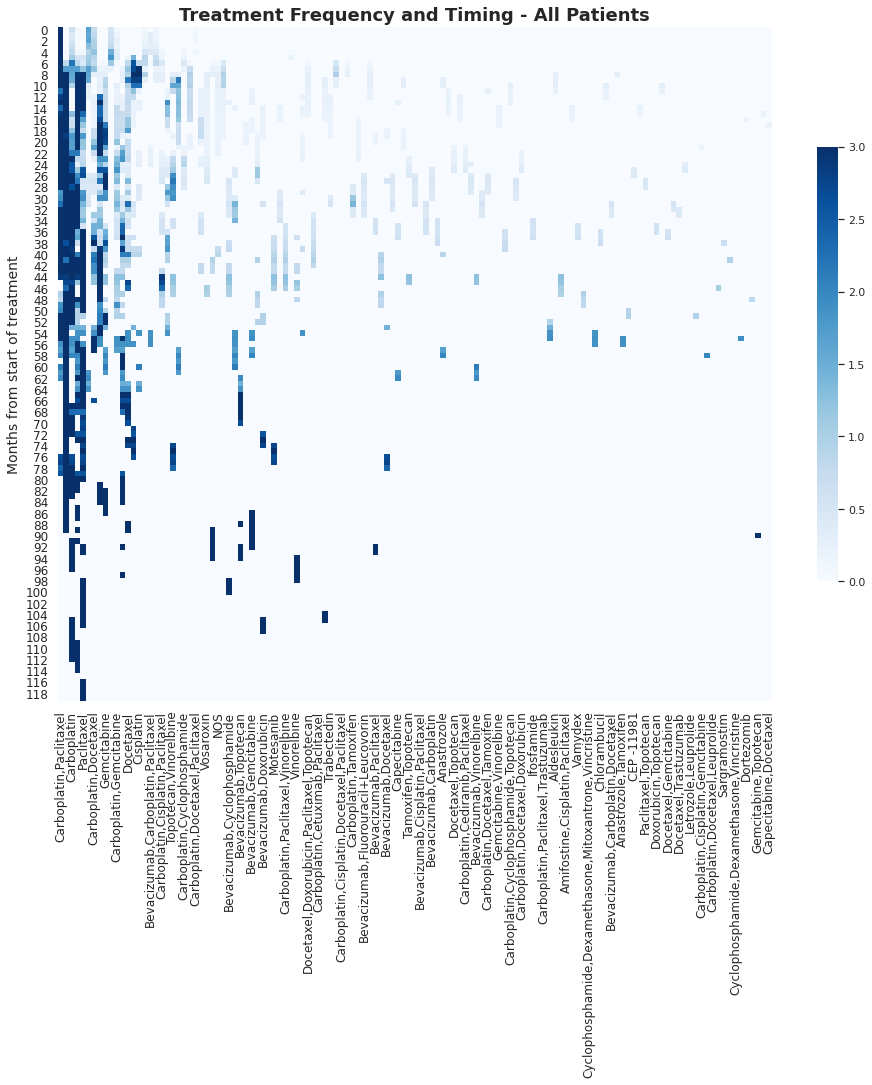

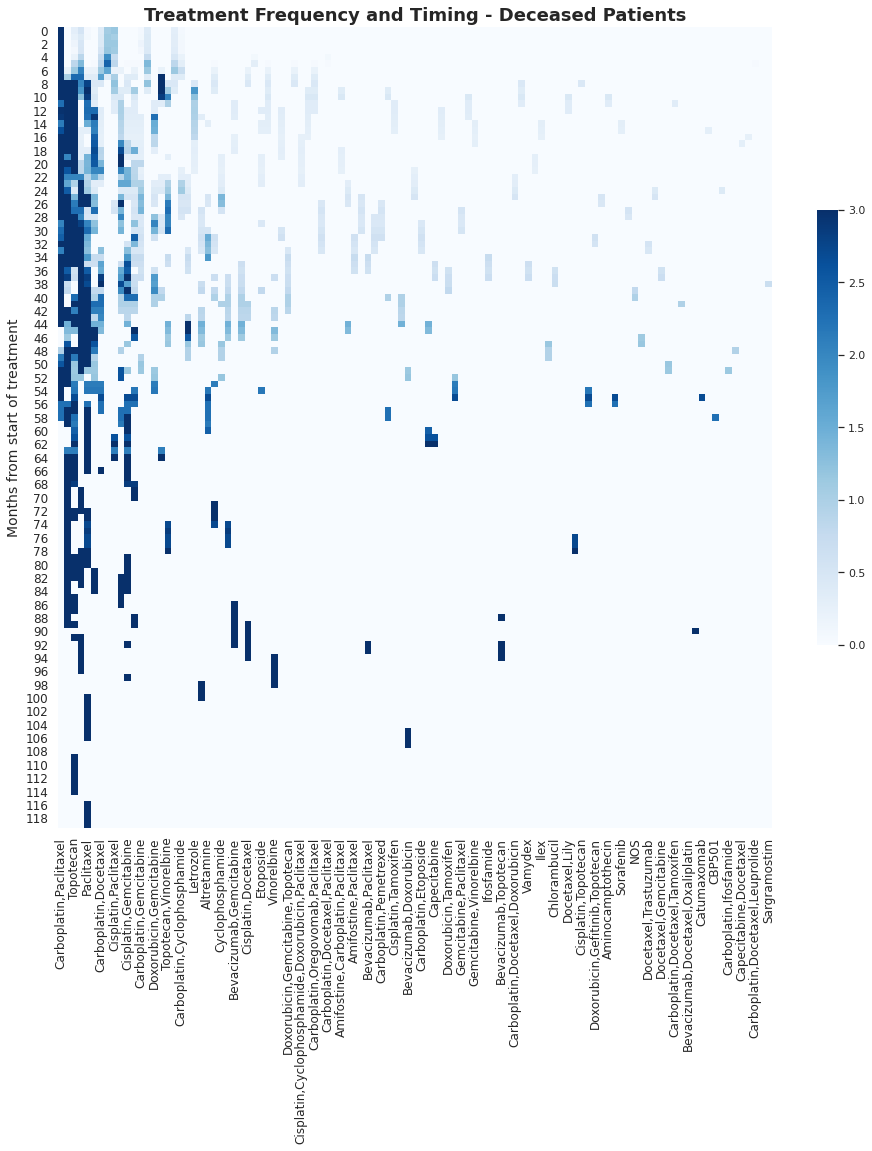

In [10]:
def freq_heat(data, fig_title, file_name):
    df_heat = data.stb.freq(['ther_str', 'months'])[['ther_str', 'months', 'count']].sort_values(by=['months', 'ther_str'])
    df_heat = df_heat.pivot_table(index=['months'], columns='ther_str', values='count').reset_index().rename_axis(None, axis=1).set_index('months')
    df_heat = df_heat.fillna(value=0).drop([''], axis=1)
    s = df_heat.sum()
    df_heat = df_heat[s.sort_values(ascending=False).index]
    # convert to z-scores
    for row in df_heat.index:
        stats.zscore(df_heat.iloc[row])
        df_heat.iloc[row] = stats.zscore(df_heat.iloc[row])
    df_heat = df_heat.fillna(value=0)

    # Make heatmap
    sns.set(font_scale=1)

    cmap = sns.color_palette("Blues", as_cmap=True)
    plt.figure(figsize=(16,16))
    plt.rcParams["font.family"] = "Arial"
    ax = sns.heatmap(data=df_heat,
                     cmap=cmap, 
                     square=1,
                     vmin=0, vmax=3,
                     cbar_kws={"shrink": .5},
                     )
    plt.title(fig_title, size=18, fontweight='bold')
    plt.ylabel('Months from start of treatment', size=14)
    plt.xticks(size=12, rotation='vertical')
    plt.yticks(size=12)
    plt.savefig(file_name)

freq_heat(df_reg, 'Treatment Frequency and Timing - All Patients', 'heat_data_all.png')
freq_heat(df_d_reg, 'Treatment Frequency and Timing - Deceased Patients', 'heat_data_d.png')

## Create MDP objects

* This should probably be the start of the next notebook

State and Action set

In [11]:
# States
state_set = ['N', 'T', 'D']

# Combos/actions
combos_all = list(lines_df_2['therapy'])
combos_all.sort()
combos_all = list(combos_all for combos_all,_ in itertools.groupby(combos_all))
print(len(combos_all))
print(combos_all[0:10])

combos_all_drugs = combos_all.copy()
combos_all_drugs.remove([])
print(combos_all_drugs[0:10]) 

# Combos for deceased patients
combos_d = list(lines_df_d['therapy'])

combos_d.sort()
combos_d = list(combos_d for combos_d,_ in itertools.groupby(combos_d))
print(len(combos_d))
print(combos_d[0:10])

combos_drugs_d = combos_d.copy()
combos_drugs_d.remove([])
print(combos_drugs_d[0:10]) 

###### "2" versions are just dropping the 'NOT SPECIFIED' value
# Race
races_all = list(lines_df_2['race'].unique())
races_all.sort()
print(races_all)
races_all2 = races_all.copy()
races_all2.remove('NOT SPECIFIED')
print(races_all2)
    # Death only dataset
races_d = list(lines_df_d['race'].unique())
races_d.sort()
print(races_d)
races_d2 = races_d.copy()
races_d2.remove('NOT SPECIFIED')
print(races_d2)

# Tumor stage
tumor_stages_all = list(lines_df_2['tumor_stage'].unique())
tumor_stages_all.sort()
print(tumor_stages_all)
tumor_stages_all2 = tumor_stages_all.copy()
tumor_stages_all2.remove('NOT SPECIFIED')
print(tumor_stages_all2)
    # Death only dataset
tumor_stages_d = list(lines_df_d['tumor_stage'].unique())
tumor_stages_d.sort()
print(tumor_stages_d)
tumor_stages_d2 = tumor_stages_d.copy()
tumor_stages_d2.remove('NOT SPECIFIED')
print(tumor_stages_d2)

# Tumor grade
tumor_grades_all = list(lines_df_2['tumor_grade'].unique())
tumor_grades_all.sort()
print(tumor_grades_all)
tumor_grades_all2 = tumor_grades_all.copy()
tumor_grades_all2.remove('NOT SPECIFIED')
print(tumor_grades_all2)
    # Death only dataset
tumor_grades_d = list(lines_df_d['tumor_grade'].unique())
tumor_grades_d.sort()
print(tumor_grades_d)
tumor_grades_d2 = tumor_grades_d.copy()
tumor_grades_d2.remove('NOT SPECIFIED')
print(tumor_grades_d2)

# Function to create random array for descriptive variables
def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

128
[[], ['Abagovomab'], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole']]
[['Abagovomab'], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole'], ['Anastrozole', 'Doxorubicin']]
108
[[], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole'], ['Anastrozole', 'Doxorubicin']]
[['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'

Static transition matrix

In [12]:
# Treatment States = {No Treatment, Treatment, Death}
# All or death-only action sets
combos = combos_d # Switch to _all when use full dataset
combos_drugs = combos_drugs_d

# Descriptive States (all or death-only)
races = races_d
races2 = races_d2
tumor_stages = tumor_stages_d
tumor_stages2 = tumor_stages_d2
tumor_grades = tumor_grades_d
tumor_grades2 = tumor_grades_d2

# Dataset to use
trans_data = df_d_reg # change to df_reg if using full dataset

Cox Proportional Hazard Regression

In [13]:
# Fit regressions
    # Survival
X_surv = trans_data.drop(['previous_lines', '', 'no_treat', 'treat', 'patient', 'therapy', 'race', 'tumor_stage', 
                         'tumor_grade', 'ther_str', 'NOT SPECIFIED_tumor_stage', 'NOT SPECIFIED_tumor_grade', 
                         'NOT SPECIFIED_race', 'treat_months'], axis=1)
cph_surv = CoxPHFitter(penalizer=0.1)
cph_surv.fit(X_surv, duration_col='months', event_col='death', robust=True) # add this to do specific cols: , formula="fin + wexp + age * prio"

    # Treatment
X_treat = trans_data.drop(['previous_lines', '', 'treat', 'death', 'patient', 'therapy', 'race', 'tumor_stage',
                         'tumor_grade', 'ther_str', 'NOT SPECIFIED_tumor_stage', 'NOT SPECIFIED_tumor_grade',
                         'NOT SPECIFIED_race'], axis=1)
cph_treat = CoxPHFitter(penalizer=0.1)
cph_treat.fit(X_treat, duration_col='treat_months', event_col='no_treat', robust=True)

<lifelines.CoxPHFitter: fitted with 5931 total observations, 3312 right-censored observations>

In [14]:
def cph_probs(data, state, months, treat_months, action, age, race, tumor_stage, tumor_grade):
    month = min(months, max(data['months']))
    treat_month = min(treat_months, max(data['treat_months']))
    if action == []:
        pass
    else:
        act_ind = combos_drugs.index(action) + 2
        
    act_arr = np.zeros(len(combos_drugs)) # sim patient vectors = 0 if 'NOT SPECIFIED'
    if action == []:
        pass
    else:
        act_arr[combos_drugs.index(action)] = 1

    x_surv = np.concatenate((np.array([age]), np.array([state_set.index(state)]), act_arr, race, tumor_stage, tumor_grade))
    x_surv = x_surv.reshape(1,-1)
    
    x_treat = np.concatenate((np.array([month]), np.array([age]), np.array([state_set.index(state)]), act_arr, race, tumor_stage, tumor_grade))
    x_treat = x_treat.reshape(1,-1)
#     haz = (base_haz * part_haz.values[0]).iloc[months].values[0]
    surv = cph_surv.predict_survival_function(x_surv).iloc[month].values[0]
    treat_prob = cph_treat.predict_survival_function(x_treat).iloc[treat_month].values[0]
    return surv, treat_prob

race_arr = np.array([0, 0, 0, 0, 1])
ts_arr = np.array([0, 0, 1, 0, 0, 0])
tg_arr = np.array([0, 0, 1, 0, 0])

# check that it works
cph_probs(trans_data, 'T', 70, 15, ['Carboplatin', 'Paclitaxel'], 80, race_arr, ts_arr, tg_arr)

(0.7674507510703572, 0.77014624846189)

In [39]:
cph_surv.baseline_survival_.to_csv('cph_surv_baseline.csv', index=False)
cph_treat.baseline_survival_.to_csv('cph_treat_baseline.csv', index=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


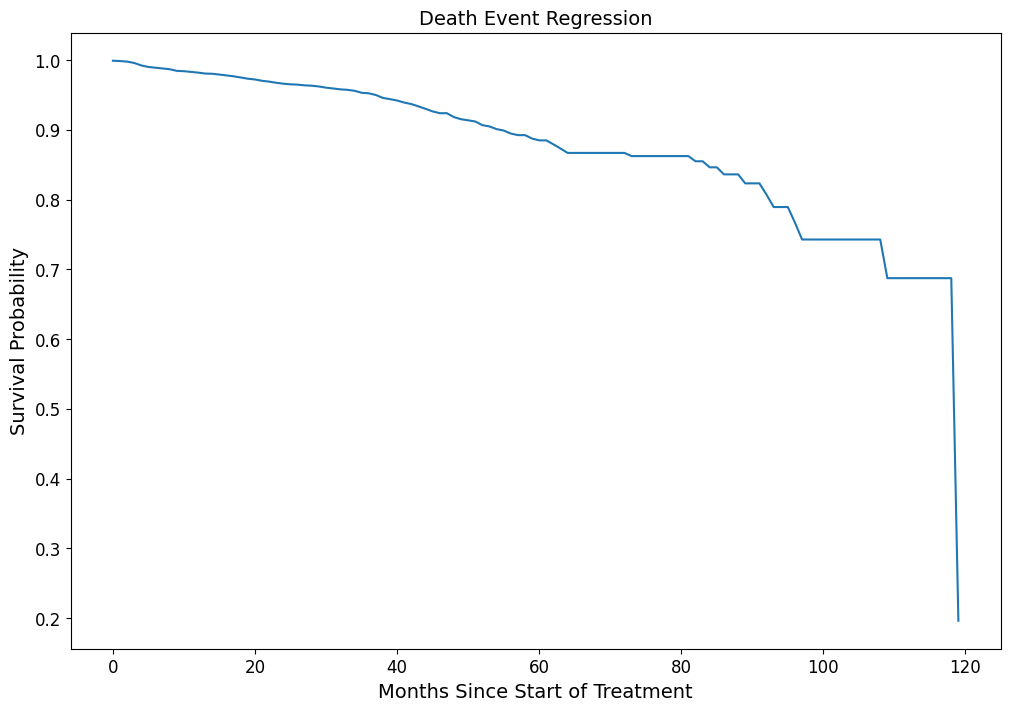

In [15]:
# CPH Death Regression Baseline Survival
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'Arial'
# cph.plot_partial_effects_on_outcome(covariates='age', values=[40, 50, 60, 70, 80], cmap='coolwarm')
plt.plot(cph_surv.baseline_survival_)
plt.title('Death Event Regression', fontsize=14)
plt.xlabel('Months Since Start of Treatment', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('baseline_surv_death.png')

# cph.print_summary()
# cph_treat.print_summary()

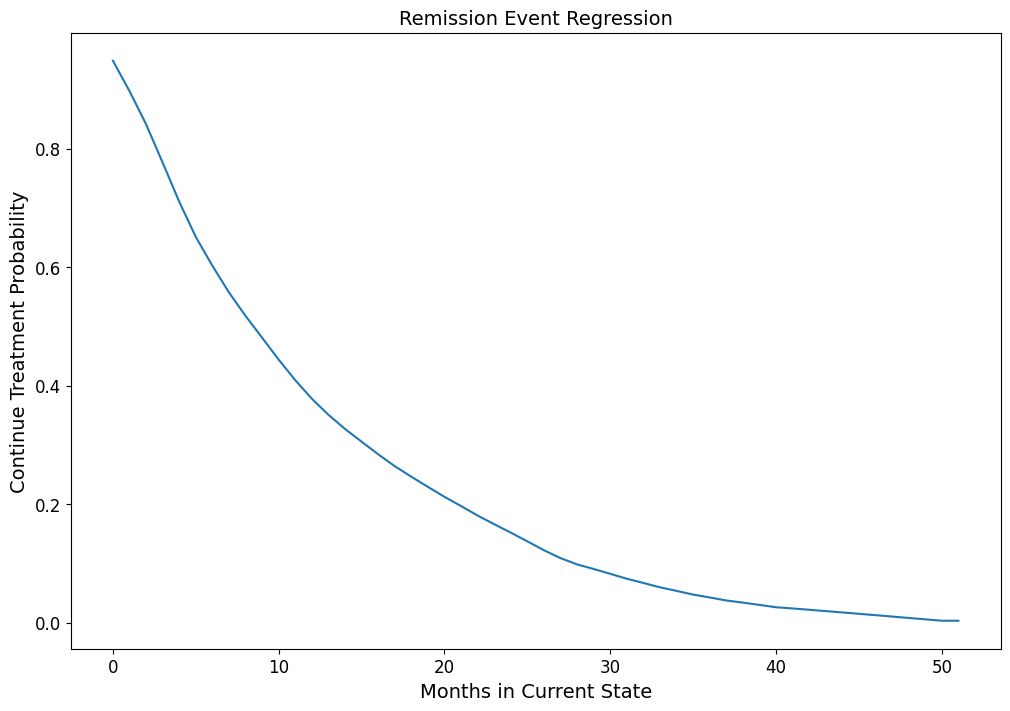

In [16]:
# CPH Remission/Recurrence Regression Baseline Survival
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'Arial'
plt.plot(cph_treat.baseline_survival_)
plt.title('Remission Event Regression', fontsize=14)
plt.xlabel('Months in Current State', fontsize=14)
plt.ylabel('Continue Treatment Probability', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('baseline_surv_recurrence.png')

In [17]:
X = np.array(trans_data.loc[:, 'months':])
# OLS Linear, event on time and treatment, only patients who died
        # Treatment prob
y = np.array(trans_data['treat'])
t_reg = sm.OLS(y, X)
t_reg = t_reg.fit()


        # No treatment prob
y = np.array(trans_data['no_treat'])
n_reg = sm.OLS(y, X)
n_reg = n_reg.fit()

        # Death prob
y = np.array(trans_data['death'])
d_reg = sm.OLS(y, X)
d_reg = d_reg.fit()

# MinMax and sum to 1 scaling for negative probs
scaler = MinMaxScaler(feature_range=(0.01, 0.99)) # maybe change min to the overall proportion of deaths to total transitions

def scaleMM(inprobs):
    scaler.fit(inprobs.reshape(-1, 1))
    outprobs = scaler.transform(inprobs)
    outprobs = outprobs / outprobs.sum()
    return outprobs

# Function to calculate transition probabilities based on regressions
def reg_probs(data, state, months, action, age, race, tumor_stage, tumor_grade):
    act_ind = combos.index(action) + 3
    race_ind = races.index(race) + len(combos) + 3
    ts_ind = tumor_stages.index(tumor_stage) + len(combos) + len(races) + 3
    tg_ind = tumor_grades.index(tumor_grade) + len(combos) + len(races) + len(tumor_stages) + 3
    x_test = np.zeros(data.shape[1]-10)
    x_test[0] = months
    x_test[1] = age
    x_test[2] = state_set.index(state)
    x_test[act_ind] = 1
    x_test[race_ind] = 1
    x_test[ts_ind] = 1
    x_test[tg_ind] = 1
    x_test = x_test.reshape(1,-1)
    probs = np.array([[n_reg.predict(x_test)[0], t_reg.predict(x_test)[0], d_reg.predict(x_test)[0]]])
    probs = scaleMM(probs)[0].tolist()
    return probs

# check that it works
# reg_probs(trans_data, 'T', 50, ['Carboplatin', 'Paclitaxel'], 58, 'WHITE', 'IIIA', 'G3')

Note: visualize probability of death over time

In [18]:
# # If want formatted regression output
# print(t_reg.summary())

Q-Network: MLP

In [19]:
# Define DQN, one hidden layer MLP for now
class DQN(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(DQN, self).__init__()
        self.fc = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.fc_out(out)
        return out

In [20]:
# Create a bigger NN
class DQN_3(nn.Module):
    def __init__(self, in_features, out_features):
        super(DQN_3, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(256, out_features)

    def forward(self, x):
        out = self.fc1(x) # in
        out = self.relu(out)
        out = self.fc2(out) # hidden 1
        out = self.relu(out)
        out = self.fc3(out) # hidden 2
        out = self.relu(out)
        out = self.fc3(out) # hidden 3
        out = self.relu(out)
        out = self.fc3(out) # hidden 4
        out = self.relu(out)
        out = self.fc3(out) # hidden 5
        out = self.relu(out)
        out = self.fc3(out) # hidden 6
        out = self.relu(out)
        out = self.fc_out(out) # out
        return out

Replay Memory

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [21]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Model training loop

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Use Q update formua: $Q^{\pi}(s,a) \leftarrow Q^{\pi}(s,a) + \alpha \cdot [r + \gamma \cdot Q^{\pi}(s', a') - Q^{\pi}(s,a)]$

In [22]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy(state_batch).gather(1, action_batch).squeeze()

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = state_action_values + ALPHA * (reward_batch + (GAMMA * next_state_values) - state_action_values)
    expected_state_action_values = expected_state_action_values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch # old version

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Environment

Designed based on: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py

State Class

In [23]:
# Globals
START_STATE = 'T'
GAMMA = 0.99
ALPHA = 0.01
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100 # Increase to slow decay
BATCH_SIZE = 100
TARGET_UPDATE = 10
IN_FEATURES = 4 + len(races2)+len(tumor_stages2)+len(tumor_grades2) # health state, months, months on treatment, age + dummy arrays

# policy = DQN(2, 100, len(combos_drugs)).to(device) # input features are the state and the number of previous states
# target_net = DQN(2, 100, len(combos_drugs)).to(device)
policy = DQN_3(IN_FEATURES, len(combos_drugs)).to(device)
target_net = DQN_3(IN_FEATURES, len(combos_drugs)).to(device)
target_net.load_state_dict(policy.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy.parameters())
memory = ReplayMemory(10000)

# State class initializes the simulated patient vector
class State:
    def __init__(self, state=START_STATE):
        self.state = state
        self.age = round(np.random.normal(trans_data['age'].mean(), trans_data['age'].std(), 1)[0])
        self.race = random.choice(races) # choose from all including 'NOT SPECIFIED'
        self.r_arr = np.zeros(len(races2)) # sim patient vectors = 0 if 'NOT SPECIFIED'
        if self.race == 'NOT SPECIFIED':
            pass
        else:
            self.r_arr[races2.index(self.race)] = 1
        self.tumor_stage = random.choice(tumor_stages) 
        self.ts_arr = np.zeros(len(tumor_stages2))
        if self.tumor_stage == 'NOT SPECIFIED':
            pass
        else:
            self.ts_arr[tumor_stages2.index(self.tumor_stage)] = 1
        self.tumor_grade = random.choice(tumor_grades)
        self.tg_arr = np.zeros(len(tumor_grades2))
        if self.tumor_grade == 'NOT SPECIFIED':
            pass
        else:
            self.tg_arr[tumor_grades2.index(self.tumor_grade)] = 1
        
        self.isEnd = False

Environment Class

In [24]:
class CancerEnv:
    def __init__(self):
        self.State = State()
        self.s_a = []
        self.treat_mo = 0
        self.round = 0
        self.actions = combos_drugs
        # initial state and action reward
        self.state_values = {'N':1, 'T':1, 'D':-1}       # not sure if need these, need action values instead. Can it be like: Combo: Value - xt?
        self.statevals_list = [1, 1, -1]      # for [N, T, D]
        self.s_a_values = {} 
        for i in state_set:
            for j in combos:
                self.s_a_values[repr([i, j])] = 0
    
    # Choose Action
    def chooseAction(self):
        # choose action with most expected value
        mx_exp_reward = 0
        exp_rate = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.round / EPS_DECAY)
        if self.State.state == 'N':
            action = []
        else:
            if np.random.uniform(0, 1) <= exp_rate:
                action = self.actions[np.random.choice(len(self.actions))]
            else:
                # greedy action
                with torch.no_grad():
                    state_t = torch.cat((torch.FloatTensor([state_set.index(self.State.state), len(self.s_a), self.treat_mo,
                                                            self.State.age]), 
                                         torch.FloatTensor(self.State.r_arr),
                                         torch.FloatTensor(self.State.ts_arr),
                                         torch.FloatTensor(self.State.tg_arr))) #torch.FloatTensor([state_set.index(self.State.state), len(self.s_a)])

                    act = policy(state_t).max(0)[1].item()
                    action = self.actions[act]
        return action

        # Update step
    def nxtPosition(self, action, months, treat_months):
        # Choose probabilities from transition matrix
#         probs = get_probs(action, self.state) # static probs
        # Get regression probs
            # OLS
#         probs = reg_probs(trans_data, self.State.state, months, action, self.State.age, self.State.race, 
#                           self.State.tumor_stage, self.State.tumor_grade)

#         nxtState = random.choices(state_set, weights=probs, k=1)[0]

            # CPH
        surv, treat_prob = cph_probs(trans_data, self.State.state, months, treat_months, action, self.State.age,
                                     self.State.r_arr, self.State.ts_arr, self.State.tg_arr)
        # Return next state
        if np.random.uniform(0,1) > surv:
            nxtState = 'D'
        else:
            nxtState = random.choices(['T', 'N'], weights=[treat_prob, 1-treat_prob], k=1)[0]
        return nxtState

    def takeAction(self, action):
        position = self.nxtPosition(action, len(self.s_a)-1, self.treat_mo)
        return position # State(state=position)
      
        # Give reward: for now, simple rewards
    def giveReward(self):
        if self.State.state == 'N':
            return 1 
        elif self.State.state == 'T':
            return 1
        elif self.State.state == 'D':
            return -1 
    
    def isEndFunc(self):
        if self.State.state == 'D':
            self.State.isEnd = True

    def reset(self):
        self.s_a = []
        self.treat_mo = 0
        self.State = State()

    def play(self, rounds=1000, verbose=True):
        since = time.time()
        total_reward_list = []
        traj_list = []
        
        while self.round < rounds:
            if self.State.isEnd:
                # back propagate
                reward = self.giveReward()
                # explicitly assign end state to reward values
                # self.s_a_values[repr([self.State.state, action])] = reward  # this is optional
                # for s in reversed(self.s_a):
                #     reward = self.s_a_values[repr([s[0], s[1]])] + self.lr * (reward - self.s_a_values[repr([s[0], s[1]])]) # I think i need to update this formula because using (s,a) now
                #     self.s_a_values[repr([s[0], s[1]])] = reward
                # Calculate total reward
                total_reward = 0
                for s in self.s_a:
                    total_reward += self.state_values[s[0]]
                if verbose:
                    print(self.s_a)
                    print('Total reward: ', total_reward)
                    print('----------------------------------------------------')
                total_reward_list.append(total_reward)
                
                if self.round % 1000 == 0:
                    time_elapsed = time.time() - since
                    print('Rounds complete: ', self.round,'/', rounds)
                    print('Time elapsed: {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))

                self.reset()
                self.round += 1
            else:
                action = self.chooseAction()
                try:
                    act_ind = torch.tensor([combos_drugs.index(action)])
                except ValueError:
                    pass
                # append trace
                self.s_a.append([self.State.state, action])
                    
                if verbose:
                    print('current state {} action {}'.format(self.State.state, action))
                
                s_t = torch.cat((torch.FloatTensor([state_set.index(self.State.state), len(self.s_a)-1, self.treat_mo, 
                                                    self.State.age]),
                                 torch.FloatTensor(self.State.r_arr),
                                 torch.FloatTensor(self.State.ts_arr),
                                 torch.FloatTensor(self.State.tg_arr))) 
                # by taking the action, it reaches the next state
                self.State.state = self.takeAction(action)
                
                # Fill simulation trajectory data
                traj_list.append([self.round, action, self.State.race, self.State.tumor_stage, self.State.tumor_grade,
                                  len(self.s_a)-1, self.treat_mo, self.State.age, state_set.index(self.State.state)])
                
                if (len(self.s_a)-1 > 0) & (self.State.state == self.s_a[-1][0]):
                    self.treat_mo += 1
                else:
                    self.treat_mo = 0
            
                # save transition vals for memory
                s_t1 = torch.cat((torch.FloatTensor([state_set.index(self.State.state), len(self.s_a), self.treat_mo,
                                                     self.State.age]),
                                  torch.FloatTensor(self.State.r_arr),
                                  torch.FloatTensor(self.State.ts_arr),
                                  torch.FloatTensor(self.State.tg_arr)))
                r_t = torch.FloatTensor([self.giveReward()])
                # store transition in memory
                if action != []:
                    memory.push(s_t, act_ind, s_t1, r_t)
                else:
                    pass
                
                # mark is end
                self.isEndFunc()
                if verbose:
                    print('nxt state', self.State.state)
                    print('---------------------')
            # perform an optimizaiton step
            optimize_model()
            # update target model
            if self.round % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy.state_dict())
        sim_trajectories = pd.DataFrame(traj_list, columns=['patient', 'therapy', 'race', 'tumor_stage','tumor_grade', 'months',
                                                            'treat_months', 'age', 'treat_state'])
        time_elapsed = time.time() - since
        print('Rounds complete: ', rounds,'/', rounds)
        print('Time elapsed: {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
        return total_reward_list, sim_trajectories

Treat patients

In [25]:
if __name__ == '__main__':
    env = CancerEnv()
    reward_hist, sim_trajectories = env.play(rounds=100000, verbose=False)
    # print(ag.s_a_values)

Rounds complete:  0 / 100000
Time elapsed: 0h 0m 0s
Rounds complete:  1000 / 100000
Time elapsed: 0h 2m 59s
Rounds complete:  2000 / 100000
Time elapsed: 0h 5m 27s
Rounds complete:  3000 / 100000
Time elapsed: 0h 7m 8s
Rounds complete:  4000 / 100000
Time elapsed: 0h 8m 58s
Rounds complete:  5000 / 100000
Time elapsed: 0h 10m 60s
Rounds complete:  6000 / 100000
Time elapsed: 0h 13m 35s
Rounds complete:  7000 / 100000
Time elapsed: 0h 15m 51s
Rounds complete:  8000 / 100000
Time elapsed: 0h 18m 2s
Rounds complete:  9000 / 100000
Time elapsed: 0h 20m 13s
Rounds complete:  10000 / 100000
Time elapsed: 0h 22m 25s
Rounds complete:  11000 / 100000
Time elapsed: 0h 24m 40s
Rounds complete:  12000 / 100000
Time elapsed: 0h 26m 54s
Rounds complete:  13000 / 100000
Time elapsed: 0h 28m 60s
Rounds complete:  14000 / 100000
Time elapsed: 0h 31m 9s
Rounds complete:  15000 / 100000
Time elapsed: 0h 33m 18s
Rounds complete:  16000 / 100000
Time elapsed: 0h 35m 50s
Rounds complete:  17000 / 100000
Tim

## Results
Copy below cells to other notebook

Total rewards

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


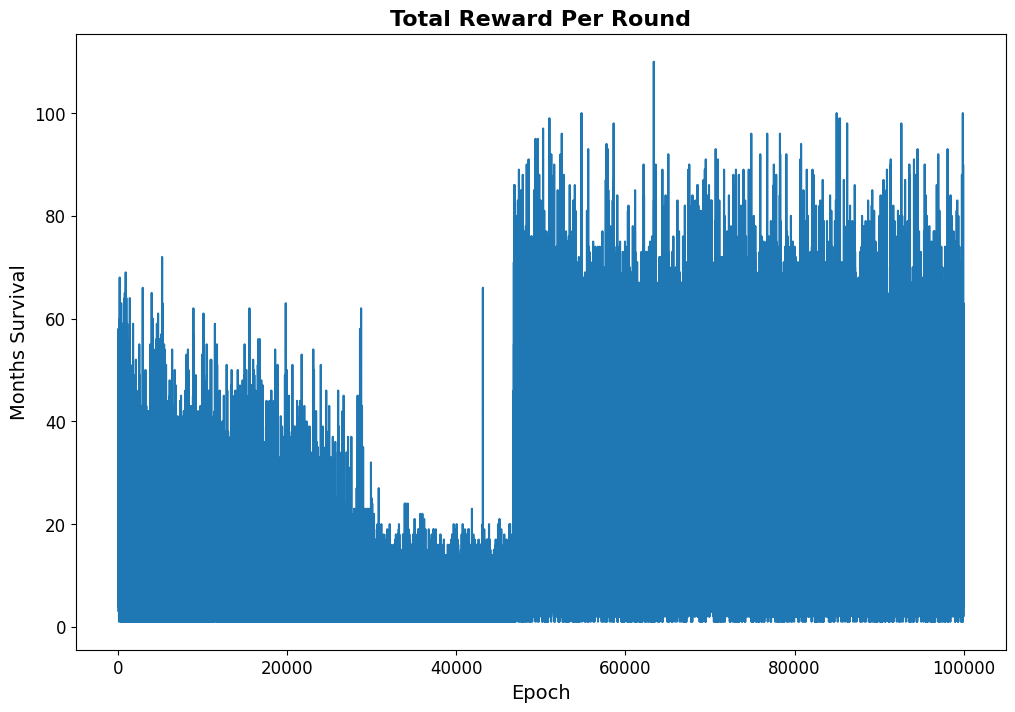

In [26]:
plt.style.use('default')
plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Arial"
plt.plot(reward_hist)
plt.title('Total Reward Per Round', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Months Survival', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('reward.png')

Moving average

In [27]:
# Reward DF
reward_df = pd.DataFrame({'mo_surv': reward_hist})
reward_df['SMA100'] = reward_df.iloc[:,0].rolling(window=100).mean()
reward_df['SMA1000'] = reward_df.iloc[:,0].rolling(window=1000).mean()
reward_df['CMA'] = reward_df.iloc[:,0].expanding(min_periods=2).mean()
reward_df['EMA100'] = reward_df.iloc[:,0].ewm(span=100, adjust=False).mean()
# Save CSV
reward_df.to_csv('reward_df.csv', index=False)
# Show
reward_df

,mo_surv,SMA100,SMA1000,CMA,EMA100
0,12,NaN,NaN,NaN,12.000000
1,17,NaN,NaN,14.500000,12.099010
2,16,NaN,NaN,15.000000,12.176257
3,5,NaN,NaN,12.500000,12.034153
4,31,NaN,NaN,16.200000,12.409714
...,...,...,...,...,...
99995,11,24.80,24.936,16.934177,25.001428
99996,4,24.77,24.930,16.934048,24.585558
99997,13,24.82,24.932,16.934009,24.356141
99998,12,24.85,24.890,16.933959,24.111465


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


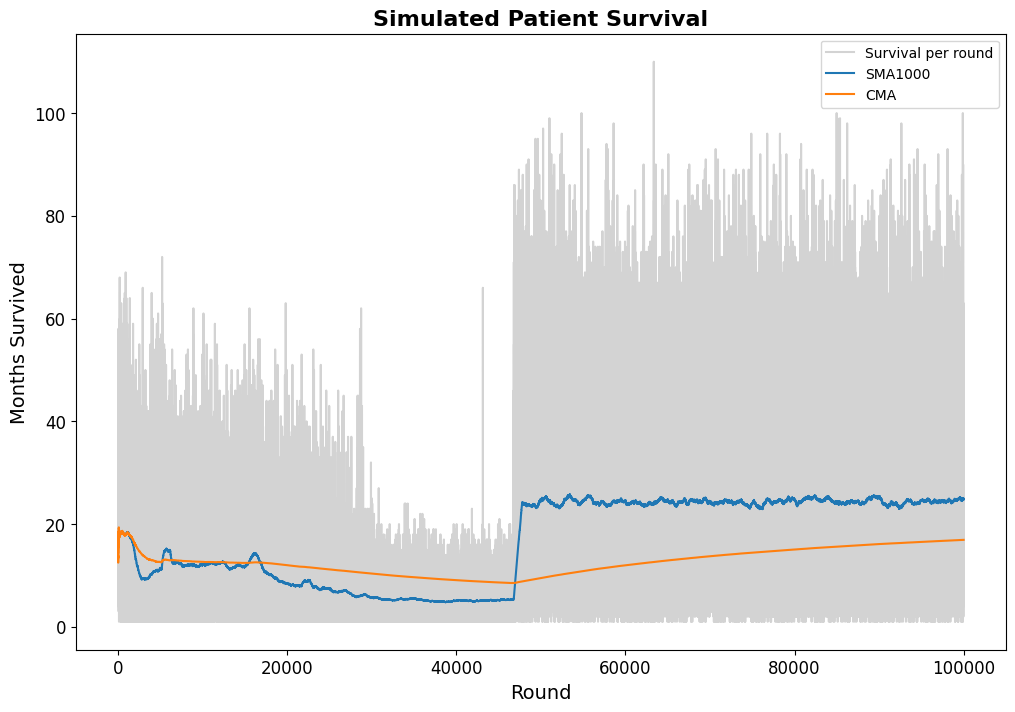

In [28]:
# Plot
plt.figure(figsize=(12,8))
# plt.rcParams["font.family"] = "Arial"
plt.plot(reward_df['mo_surv'], label='Survival per round', color='lightgray')
# plt.plot(reward_df['SMA100'], label='SMA100')
plt.plot(reward_df['SMA1000'], label='SMA1000')
# plt.plot(reward_df['EMA100'], label='EMA')
plt.plot(reward_df['CMA'], label='CMA')
plt.title('Simulated Patient Survival', fontsize=16, fontweight='bold')
plt.xlabel('Round', fontsize=14)
plt.ylabel('Months Survived', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('sim_survival.png')

Simulated trajectories data

In [29]:
# Save CSV
sim_trajectories.to_csv('sim_trajectories.csv', index=False)

# Show
sim_trajectories

,patient,therapy,race,tumor_stage,tumor_grade,months,treat_months,age,treat_state
0,0,"[Gemcitabine, Topotecan]",WHITE,IIIC,GX,0,0,42,0
1,0,[],WHITE,IIIC,GX,1,0,42,1
2,0,[Anastrozole],WHITE,IIIC,GX,2,0,42,1
3,0,"[Carboplatin, Paclitaxel]",WHITE,IIIC,GX,3,1,42,1
4,0,"[Carboplatin, Docetaxel, Paclitaxel]",WHITE,IIIC,GX,4,2,42,1
...,...,...,...,...,...,...,...,...,...
1693432,99999,[Aldesleukin],WHITE,IIB,G2,53,1,57,1
1693433,99999,[Aldesleukin],WHITE,IIB,G2,54,2,57,1
1693434,99999,[Aldesleukin],WHITE,IIB,G2,55,3,57,1
1693435,99999,[Aldesleukin],WHITE,IIB,G2,56,4,57,0


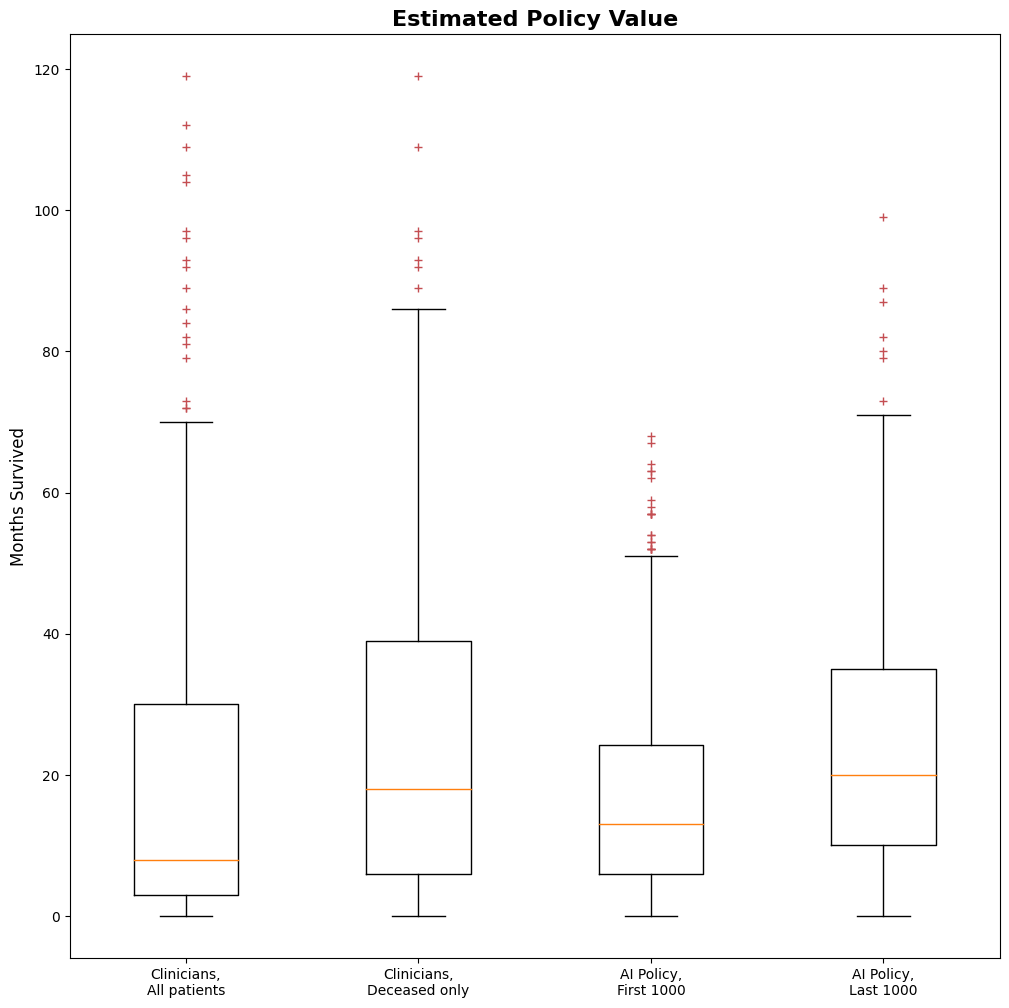

In [36]:
# Average value plots
    # Clinician data
clinician_val = df_reg[['patient', 'months']].groupby('patient').max()
clinician_val_d = df_d_reg[['patient', 'months']].groupby('patient').max()
    # Simulation data
ai_val = sim_trajectories[['patient', 'months']].groupby('patient').max()

plt.style.use('default')
plt.figure(figsize=(12,12))
plt.boxplot([clinician_val['months'], clinician_val_d['months'], ai_val[0:1000]['months'], ai_val[-1000:]['months']],
            labels=['Clinicians,\nAll patients', 'Clinicians,\nDeceased only', 'AI Policy,\nFirst 1000', 
                    'AI Policy,\nLast 1000'],
            flierprops=dict(markeredgecolor='r', marker='+'))
plt.title('Estimated Policy Value', fontsize=16, fontweight='bold')
plt.ylabel('Months Survived', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('policy_val.png')

Simulation Heatmap

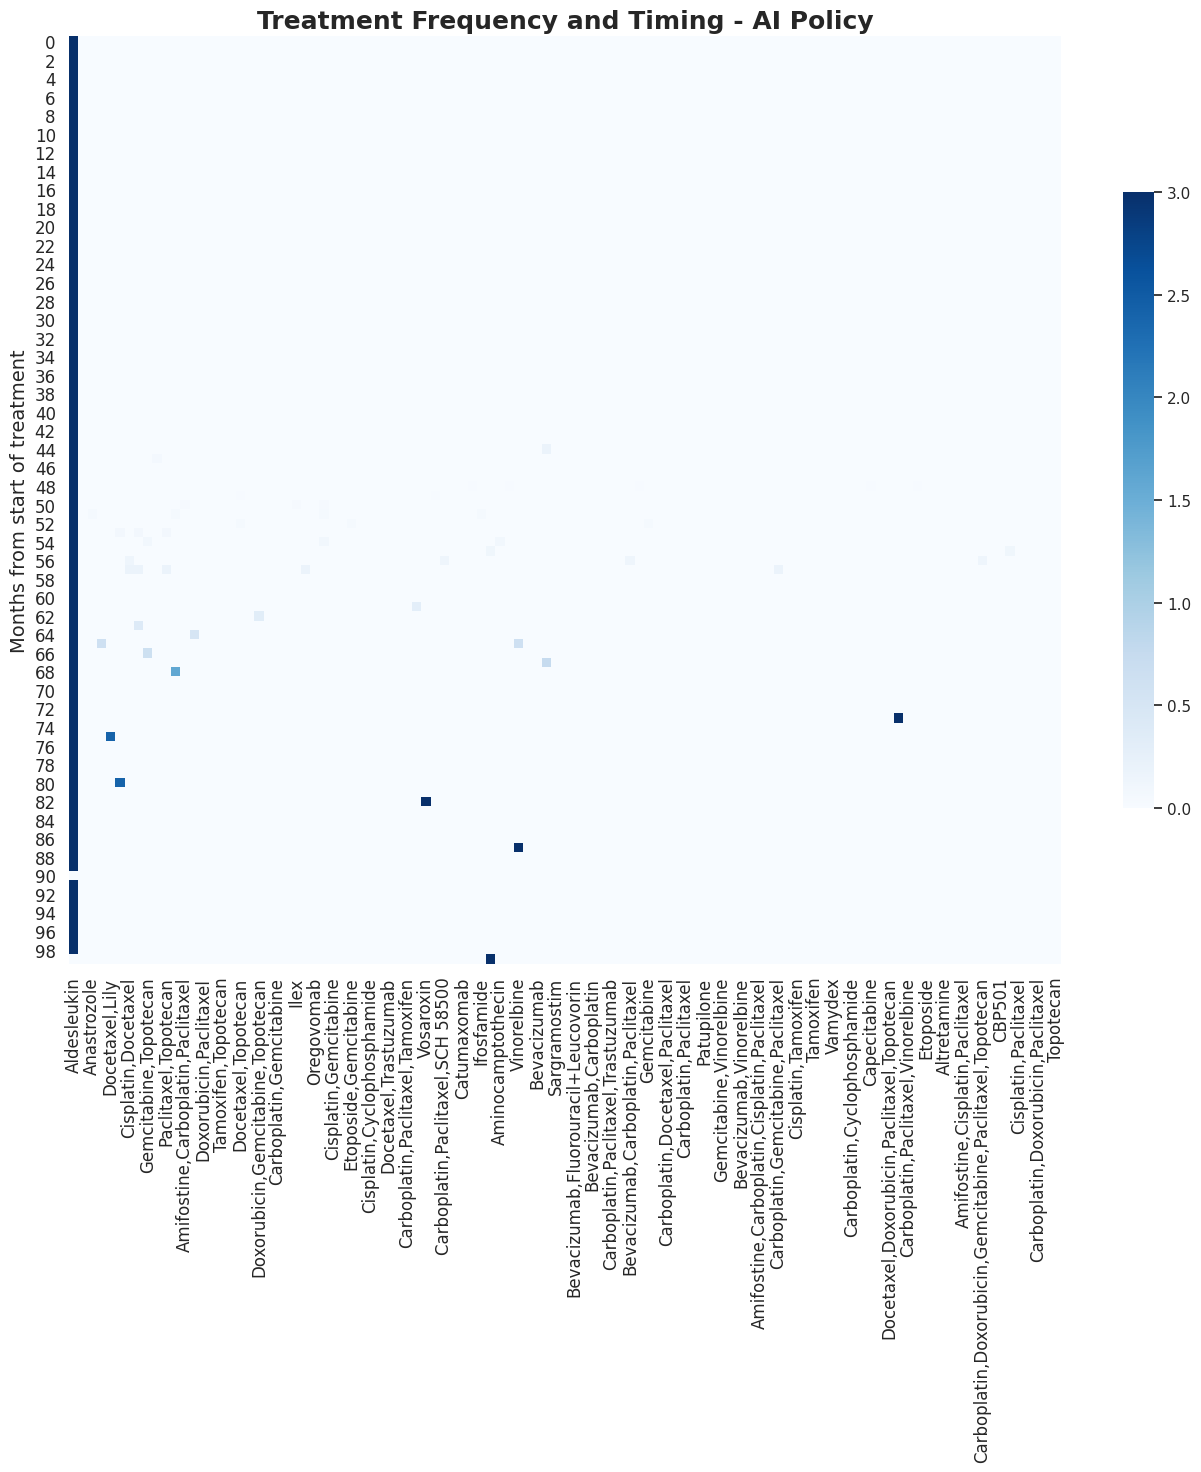

In [31]:
sim_last1000 = sim_trajectories.loc[sim_trajectories['patient'] >= sim_trajectories['patient'].max()-1000].reset_index(drop=True)

sim_last1000['ther_str'] = [','.join(map(str, l)) for l in sim_last1000['therapy']]

sim_last1000.to_csv('sim_last1000.csv', index=False)

freq_heat(sim_last1000, 'Treatment Frequency and Timing - AI Policy', 'heat_data_ai.png')

## Scratch/notes

Notes
* Add in "remission" as a state (i.e. no treatment)
  - Calculate similar to probability of death: probability that a no-treatment period follows a treatment
  - Then need to calculate probability following "remission" for each:
    - Death
    - remission, i.e. no treatment
    - More treatment i.e. "progression/recurrence" 
  - No-treatment ("[]") will not be in the action set
    - Unless already in the no-treatment state
    - Importantly, this means that the agent cannot decide to take a patient off of treatement. Not being on chemo is not a choice made by the AI "doctor", but rather, is a result of the previous treatment. Agent can, however, choose not to add drugs if already achieved remission (i.e. in the no-treatment state) 

* "Grid world" verion of action space
  - 56 dimensional object with up to 5 drugs activated at once
  - Action set is [Start drug {n}, Stop drug {n}, Do nothing]
    - Cannot [Stop drug {n}] if resulting state is no treatment
    - Cannot [Start drug {n}] if resulting len(combo) > 5
    - Cannot start a drug that is already in the combo
  - \> 4mm possible combinations, only 127 drug combos in data - is this necessary? 

* Rewards
  - I think in the final version this should be a probability distribution returning a number of days of survival/until treatment failure after each action
  - For starters, just try to get the average days survived when therapy doesn't result in death.
  - Also need to think of something for when patients don't die
    - Maybe just probability of death and a final non-death stop state?
    - Death vs. no death in the end doesn't matter unless the no deaths get a final reward

* Bellman action value equation: Q(s,a) = r + γ(max(Q(s’,a’))
  - "This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in"

Intermittant reward matrix for each patient

In [32]:
# fix because including no drug periods and using df

# tcga_rewards = {}
# for barcode in tcga_lines_keys:
#     rewards = []
#     for line in range(len(tcga_drug_lines[barcode])):
#         try:
#             rewards.append(tcga_drug_lines[barcode][line+1][0] - tcga_drug_lines[barcode][line][0])
#         except:
#             rewards.append(tcga_ov_1_keep.loc[tcga_ov_1_keep['bcr_patient_barcode'] == barcode, 'total_days_overall_survival'].iloc[0] - tcga_drug_lines[barcode][line][0])

#     tcga_rewards[barcode] = rewards

# tcga_rewards

In [33]:
# negs = []
# for barcode in tcga_rewards:
#     if tcga_rewards[barcode][-1] < 0:
#         negs.append(barcode)

# negs

In [34]:
# Add in final state for each patient: [time, 'death']
# Figure out what to do with patients where overall survival is < the end of the last therapy line